In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import datasets

In [3]:
def Fig1_svd(A, k, p):
    """
    A = QQ'A = QB = QUhatDV' = UDV'
    parameters:
        A - m*n matrix
        k - target rank
        p - over-sampling parameter
    Outputs:
        matrices U,D,V in an approximate rank-(k+p) svd of A
    """
    m, n = A.shape
    # form an n*(k + p) Gaussian random matrix G
    G = np.random.rand(n, k+p)
    # form the sample matrix Y = AG.
    Y = A@G
    # orthonormalize the columns of the sample matrix Q = orth(Y)
    Q = linalg.orth(Y)
    # form the (k + p) * n matrix B = Q'*A
    B = Q.T@A
    # form the svd of the small matrix B
    Uhat, D, Vt = np.linalg.svd(B, full_matrices=False)
    V = Vt.T
    # drop the last p components
    Uhat = Uhat[:,:k]; D = D[:k]; V = V[:,:k];
    # form U = Q * Uhat
    U = Q@Uhat
    return U, D, V, Q

In [4]:
def Fig3_svd(A, k, p):
    # Stage A
    m, n = A.shape
    G_c = np.random.randn(n, k+p)
    G_r = np.random.randn(m, k+p)
    Y_c = A @ G_c
    Y_r = np.transpose(A) @ G_r
    # potential source of error
    Q_c = linalg.orth(Y_c)
    Q_c = Q_c[:,:k]
    Q_r = linalg.orth(Y_r)
    Q_r = Q_r[:,:k]
    # Stage B
    # construct the linear system
    G = np.bmat([[G_r.T@Q_c,np.zeros((k+p,k))],[np.zeros((k+p,k)),G_c.T@Q_r],[np.eye(k),-np.eye(k)]])
    H = np.vstack((Y_r.T@Q_r,Y_c.T@Q_c,np.zeros((k,k))))
    CCT = np.linalg.lstsq(G,H,rcond = None)[0]
    C = CCT[:k,:]
    uh, D, vh = np.linalg.svd(C, full_matrices=False)
    U = Q_c @ uh
    V = Q_r @ vh.T
    return U, D, V, Q_c, Q_r

In [5]:
# classical algorithm  for svd?
def classical(A, k):
    """
    Given an m × n matrix A and integers k,
    generates low-rank approximation and error.
    """
    u, d, v = np.linalg.svd(A, full_matrices=False)
    return u[:,:k], d[:k], v[:,:k], d[k]

In [16]:
def esti_error(A,Q,r):
    # draw a sequence of standard Guassian vectors
    # generate the estimated error and probability
    m, n = A.shape
    error = 10*np.sqrt(2/np.pi)*max([np.linalg.norm(A@np.random.rand(n)-Q@(Q.T@(A@np.random.rand(n))),2) for i in range(r)])
    p = 1 - 10**(-r)
    return error, p

Text(0.5, 1.0, 'computational time')

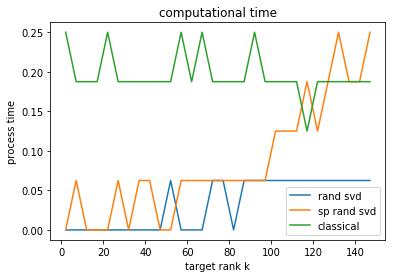

In [20]:
A = datasets.make_low_rank_matrix(500,500,30)
p = 10
time_cost_1 = []
time_cost_2 = []
time_cost_3 = []
for k in range(2,150,5):
    start_time_3 = time.process_time()
    classical(A,k)
    cost3 = time.process_time() - start_time_3
    time_cost_3.append(cost3)
    start_time_1 = time.process_time()
    Fig1_svd(A,k,p)
    cost1 = time.process_time() - start_time_1
    time_cost_1.append(cost1)
    start_time_2 = time.process_time()
    Fig3_svd(A,k,p)
    cost2 = time.process_time() - start_time_2
    time_cost_2.append(cost2)
plt.plot(range(2,150,5),time_cost_1,label='rand svd')
plt.plot(range(2,150,5),time_cost_2,label='sp rand svd')
plt.plot(range(2,150,5),time_cost_3,label='classical')
plt.legend()
plt.xlabel('target rank k')
plt.ylabel('process time')
plt.title('computational time')

In [28]:
A = datasets.make_low_rank_matrix(500,200,30)
def error_exp(A,p):
    err_class=[]
    err_1=[]
    err_3_c=[]
    err_3_r=[]
    for k in range(5,100,10):
        err_class.append(classical(A,k)[3])
        Q = Fig1_svd(A,k,p)[3]
        Qc= Fig3_svd(A,k,p)[-2]
        Qr = Fig3_svd(A,k,p)[-1]
        err_3_c.append(np.linalg.norm(A-Qc@Qc.T@A,2))
        err_3_r.append(np.linalg.norm(A-A@Qr@Qr.T,2))
        err_1.append(np.linalg.norm(A-Q@Q.T@A,2))
    return err_class,err_1,err_3_c,err_3_r

In [33]:
err_class,err_1,err_3_c,err_3_r=error_exp(A,5)
err_class_10,err_1_10,err_3_c_10,err_3_r_10=error_exp(A,10)

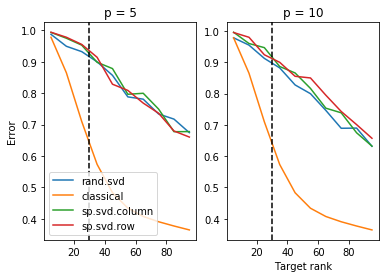

In [44]:
ax1=plt.subplot(121);ax2=plt.subplot(122)
ax1.plot(range(5,100,10),err_1,label='rand.svd')
ax1.plot(range(5,100,10),err_class,label='classical')
ax1.plot(range(5,100,10),err_3_c,label='sp.svd.column')
ax1.plot(range(5,100,10),err_3_r,label='sp.svd.row')
ax1.legend(loc=0)
ax1.set_title('p = 5')
ax1.set_ylabel('Error')
ax1.axvline(x=30,linestyle='--',color='k')
ax2.plot(range(5,100,10),err_1_10,label='rand.svd')
ax2.plot(range(5,100,10),err_class_10,label='classical')
ax2.plot(range(5,100,10),err_3_c_10,label='sp.svd.column')
ax2.plot(range(5,100,10),err_3_r_10,label='sp.svd.row')
ax2.set_title('p = 10')
ax2.set_xlabel('Target rank')
ax2.axvline(x=30,linestyle='--',color='k')

In [16]:
import imageio
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import os

def imgMatrix(directory):
    # Set gather all the images in an w*h x n array
    imgMatrix = []
    for imgName in os.listdir(directory):
        img = imageio.imread(os.path.abspath(directory) + "/" + imgName)
        img = np.transpose(np.array(img.flatten()))
        imgMatrix.append(img)
    imgMatrix = normalize(np.transpose(np.array(imgMatrix)))
    return imgMatrix

In [17]:
faceMatrix= imgMatrix("D:/study/19spr/math 490/faces")
faceMatrix=faceMatrix-np.mean(faceMatrix,axis=1).reshape(77760,1)
faceMatrix.shape

(77760, 164)

In [11]:
# doing a classical svd and notice the singular value decays rapidly

In [17]:
u,d,v,e = classical(faceMatrix,163)

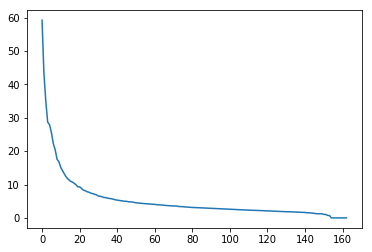

In [18]:
plt.plot(range(len(d)),d)

In [22]:
# 89.7% of variance is explained by first 30 column vectors
sum(d[:30]**2)/sum(d**2)

0.8968368655369306

In [23]:
# test on target rank
def pos_err_esti(inputMat,i,g):
    error=[]
    prob = []
    for k in range(2,30):
        Q = Fig1_svd(inputMat,k,g)[3]
        e,p = esti_error(inputMat,Q,i)
        error.append(e)
        prob.append(p)
    return error, prob

In [47]:
e_5,p5 = pos_err_esti(faceMatrix,5,5)

In [48]:
e_2,p2 = pos_err_esti(faceMatrix,2,5)

In [49]:
e_3,p3 = pos_err_esti(faceMatrix,3,5)

In [50]:
e_4,p4 = pos_err_esti(faceMatrix,4,5)

In [51]:
e_10,p10 = pos_err_esti(faceMatrix,10,5)

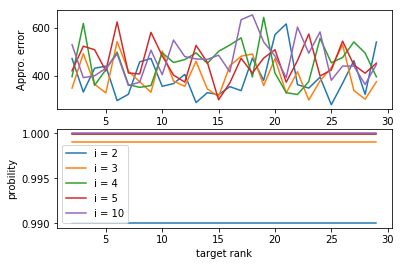

In [58]:
ax1=plt.subplot(211);ax2=plt.subplot(212)
ax1.plot(range(2,30),e_2,label='i = 2')
ax1.plot(range(2,30),e_3,label='i = 3')
ax1.plot(range(2,30),e_4,label='i = 4')
ax1.plot(range(2,30),e_5,label='i = 5')
ax1.plot(range(2,30),e_10,label='i = 10')
ax1.set_ylabel('Appro. error')
ax2.plot(range(2,30),p2,label='i = 2')
ax2.plot(range(2,30),p3,label='i = 3')
ax2.plot(range(2,30),p4,label='i = 4')
ax2.plot(range(2,30),p5,label='i = 5')
ax2.plot(range(2,30),p10,label='i = 10')
ax2.set_xlabel('target rank')
ax2.set_ylabel('probility')
ax2.legend(loc=0)

In [53]:
# target rank = 7 perform well
error_matrix=np.vstack([np.asarray(e_5),np.asarray(e_2),np.asarray(e_3),np.asarray(e_4),np.asarray(e_10)])
np.argmin(np.mean(error_matrix,axis=0))+2

7

In [55]:
# test on oversampling parameter
err3=[]
err4=[]
err5=[]
for p in range(0,15):
    Q = Fig1_svd(faceMatrix,7,p)[3]
    e3 = esti_error(faceMatrix,Q,3)[0]
    e4 = esti_error(faceMatrix,Q,4)[0]
    e5 = esti_error(faceMatrix,Q,5)[0]
    err3.append(e3)
    err4.append(e4)
    err5.append(e5)

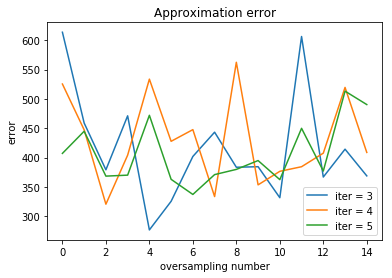

In [56]:
plt.plot(range(0,15),err3,label='iter = 3')
plt.plot(range(0,15),err4,label='iter = 4')
plt.plot(range(0,15),err5,label='iter = 5')
plt.xlabel('oversampling number')
plt.ylabel('error')
plt.title('Approximation error')
plt.legend(loc=0)

In [57]:
err_mat=np.vstack([np.asarray(err3),np.asarray(err4),np.asarray(err5)])
np.argmin(np.mean(err_mat,axis=0))

2

In [8]:
# decide to use target rank = 7 & oversampling parameter = 2
U, D, V,Q = Fig1_svd(faceMatrix, 7, 2)

In [66]:
u0,d,v0,e = classical(faceMatrix,7)

In [68]:
u2,d2,v2 = Fig3_svd(faceMatrix, 7, 2)[:3]

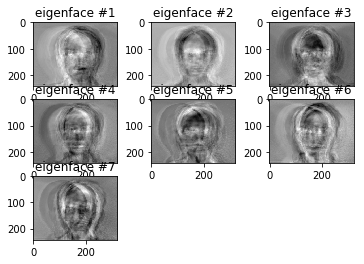

In [64]:
for i in range(1,8):
    plt.subplot(3,3,i)
    plt.imshow((U[:,i-1]).reshape(243, 320),cmap="gray")
    plt.title("eigenface #%s"%i)
plt.show()

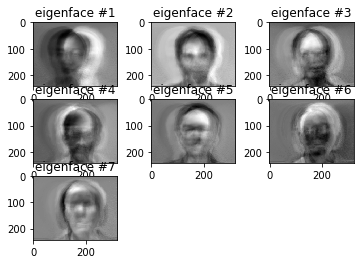

In [67]:
for i in range(1,8):
    plt.subplot(3,3,i)
    plt.imshow((u0[:,i-1]).reshape(243, 320),cmap="gray")
    plt.title("eigenface #%s"%i)
plt.show()

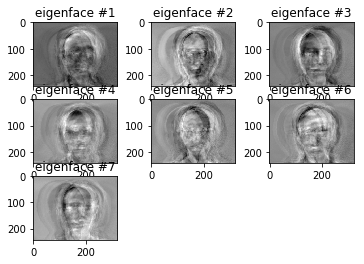

In [69]:
for i in range(1,8):
    plt.subplot(3,3,i)
    plt.imshow((u2[:,i-1]).reshape(243, 320),cmap="gray")
    plt.title("eigenface #%s"%i)
plt.show()

In [1]:
# import a single image and reshape to a column vector g
# solve a least square equation: U*s = g for s
#where U is the eigenface vector, then s is the linear combination component
# show the image of g and U*s, compare the similariry
# repeat the same procedure for different algo.